In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve,auc

# PRE PROCESSING THE DATA

In [2]:
columns = [
    "status_checking_account",
    "duration_months",
    "credit_history",
    "purpose",
    "credit_amount",
    "savings_account",
    "employment_since",
    "installment_rate",
    "personal_status_sex",
    "other_debtors",
    "present_residence_since",
    "property",
    "age",
    "other_installment_plans",
    "housing",
    "existing_credits",
    "job",
    "num_dependents",
    "telephone",
    "foreign_worker",
    "credit_risk"
]


In [3]:
df=pd.read_csv("/kaggle/input/credit-risk-dataset/german.data",sep=r"\s+",header=None,names=columns)

In [4]:
print(df.head())
print(df.shape)
df.isnull().sum()

  status_checking_account  duration_months credit_history purpose  \
0                     A11                6            A34     A43   
1                     A12               48            A32     A43   
2                     A14               12            A34     A46   
3                     A11               42            A32     A42   
4                     A11               24            A33     A40   

   credit_amount savings_account employment_since  installment_rate  \
0           1169             A65              A75                 4   
1           5951             A61              A73                 2   
2           2096             A61              A74                 2   
3           7882             A61              A74                 2   
4           4870             A61              A73                 3   

  personal_status_sex other_debtors  ...  property age  \
0                 A93          A101  ...      A121  67   
1                 A92          A101  ...  

status_checking_account    0
duration_months            0
credit_history             0
purpose                    0
credit_amount              0
savings_account            0
employment_since           0
installment_rate           0
personal_status_sex        0
other_debtors              0
present_residence_since    0
property                   0
age                        0
other_installment_plans    0
housing                    0
existing_credits           0
job                        0
num_dependents             0
telephone                  0
foreign_worker             0
credit_risk                0
dtype: int64

In [5]:
df["credit_risk"]=df["credit_risk"].map({1:1,2:0})

In [6]:
numerical_features = [
    "duration_months",
    "credit_amount",
    "installment_rate",
    "present_residence_since",
    "age",
    "existing_credits",
    "num_dependents"
]

categorical_features = [
    "status_checking_account",
    "credit_history",
    "purpose",
    "savings_account",
    "employment_since",
    "personal_status_sex",
    "other_debtors",
    "property",
    "other_installment_plans",
    "housing",
    "job",
    "telephone",
    "foreign_worker"
]

In [7]:
df_encoded=pd.get_dummies(df,columns=categorical_features,drop_first=True)

In [8]:
scaler=StandardScaler()
df_encoded[numerical_features]=scaler.fit_transform(df_encoded[numerical_features])

In [9]:
X=df_encoded.drop("credit_risk",axis=1)
y=df_encoded["credit_risk"]

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [10]:
scaler.fit(X_train[numerical_features])
X_train[numerical_features]=scaler.transform(X_train[numerical_features])
X_test[numerical_features]=scaler.transform(X_test[numerical_features])

In [11]:
print(X_train.shape)
print(X_test.shape)
y_train.mean()

(800, 48)
(200, 48)


np.float64(0.7)

In [12]:
X_train.to_csv("/kaggle/working/X_train.csv", index=False)
X_test.to_csv("/kaggle/working/X_test.csv", index=False)
y_train.to_csv("/kaggle/working/y_train.csv", index=False)
y_test.to_csv("/kaggle/working/y_test.csv", index=False)

# MODEL BUILDING FROM SCRATCH

In [13]:
X_train_np = X_train.values.astype(np.float64)
X_test_np = X_test.values.astype(np.float64)

y_train_np = y_train.values.astype(np.float64)
y_test_np = y_test.values.astype(np.float64)


In [14]:
def binary_cross_entropy(y_true,y_pred,eps=1e-15):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    loss = -np.mean(
        y_true * np.log(y_pred) +
        (1 - y_true) * np.log(1 - y_pred)
    )
    return loss

In [15]:
class LogisticRegression:
    def __init__(self, lr=0.01, n_iters=2000, l2_lambda=0.0):
        self.lr = lr
        self.n_iters = n_iters
        self.l2_lambda = l2_lambda
        self.weights = None
        self.bias = None
        self.loss_history = []

    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0.0

        for i in range(self.n_iters):
            linear_output = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear_output)

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y)) \
                 + self.l2_lambda * self.weights
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            loss = binary_cross_entropy(y, y_pred)
            self.loss_history.append(loss)

            if i % 200 == 0:
                print(f"Iter {i} | Loss: {loss:.4f}")

    def predict_proba(self, X):
        return self._sigmoid(np.dot(X, self.weights) + self.bias)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


In [16]:
model=LogisticRegression(lr=0.01,n_iters=2000,l2_lambda=0.01)

model.fit(X_train_np,y_train_np)

y_pred=model.predict(X_test_np)
y_proba = model.predict_proba(X_test_np)

fpr, tpr, thresholds = roc_curve(y_test_np, y_proba)
roc_auc = auc(fpr, tpr)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))

Iter 0 | Loss: 0.6931
Iter 200 | Loss: 0.5607
Iter 400 | Loss: 0.5404
Iter 600 | Loss: 0.5289
Iter 800 | Loss: 0.5207
Iter 1000 | Loss: 0.5143
Iter 1200 | Loss: 0.5092
Iter 1400 | Loss: 0.5049
Iter 1600 | Loss: 0.5013
Iter 1800 | Loss: 0.4982
Accuracy: 0.72
ROC-AUC: 0.7625


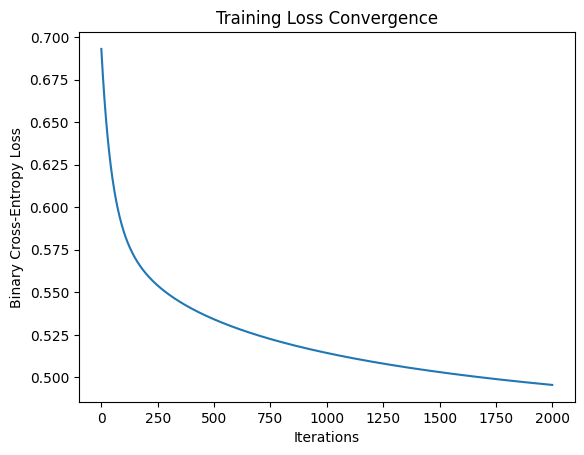

In [17]:
plt.figure()
plt.plot(model.loss_history)
plt.xlabel("Iterations")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Training Loss Convergence")
plt.show()


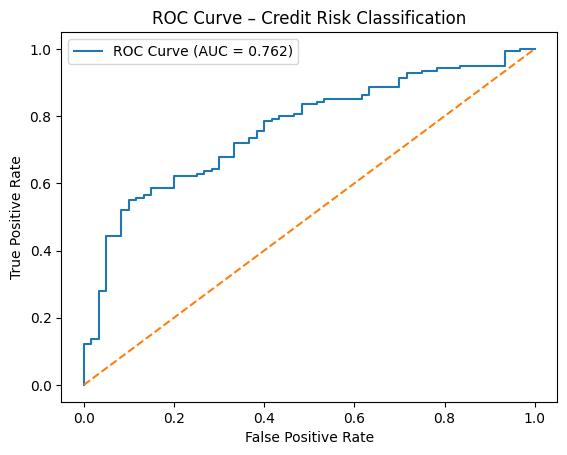

In [18]:
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Credit Risk Classification")
plt.legend()
plt.show()